<a href="https://colab.research.google.com/github/ValentinCord/HandsOnAI_2/blob/main/NLP_DataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip3 install transformers
!pip3 install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 18.8 MB/s 
     |████████████████████████████████| 7.6 MB 57.8 MB/s 
     |████████████████████████████████| 182 kB 49.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 16.3 MB/s 
     |████████████████████████████████| 132 kB 56.7 MB/s 
     |████████████████████████████████| 212 kB 50.3 MB/s 
     |████████████████████████████████| 127 kB 68.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [81]:
# basics 
import os
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from google.colab import drive

# transformers 
import torch
from datasets import load_dataset
from transformers import pipeline, AutoTokenizer
from transformers import CamembertModel, CamembertTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# nltk 
from collections import defaultdict
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop=set(stopwords.words('french'))

# plot 
import matplotlib.pyplot as plt 
import seaborn as sns 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Lecture et analyse pandas

In [5]:
train_path = '/content/drive/MyDrive/HandOnAI_2_NLP/fake_train.csv'
test_path = '/content/drive/MyDrive/HandOnAI_2_NLP/fake_test.csv'

In [6]:
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [7]:
df_train.head()

,Unnamed: 0,data,label,target_name
0,0,Au 22e jour consécutif de la grève reconductib...,0,News
1,1,"Depuis plusieurs mois, les initiatives des che...",0,News
2,2,Google vient d'introduire une mise à jour de...,0,News
3,3,Portrait. Chacun s’empresse autour d’elle tan...,0,News
4,4,« Il n’y a pas de risque de pénurie » de carbu...,0,News


In [8]:
df_train['label'].value_counts()

0    816
1    642
Name: label, dtype: int64

In [9]:
df_train['target_name'].value_counts()

News         816
Fake News    642
Name: target_name, dtype: int64

In [10]:
df_train = df_train.drop(['Unnamed: 0', 'target_name'], axis = 1)
df_test = df_test.drop(['Unnamed: 0', 'target_name'], axis = 1)

In [51]:
df_train['len_data'] = df_train['data'].apply(lambda x: len(x))
df_test['len_data'] = df_test['data'].apply(lambda x: len(x))

In [ ]:
df_train['log_len_data'] = np.log(df_train['len_data'])
df_test['log_len_data'] = np.log(df_test['len_data'])

In [52]:
df_train.head()

,data,label,len_data,nb_tokens,log_nb_tokens
0,Au 22e jour consécutif de la grève reconductib...,0,631,141,4.948760
1,"Depuis plusieurs mois, les initiatives des che...",0,2610,538,6.287859
2,Google vient d'introduire une mise à jour de...,0,2231,543,6.297109
3,Portrait. Chacun s’empresse autour d’elle tan...,0,2990,730,6.593045
4,« Il n’y a pas de risque de pénurie » de carbu...,0,1296,289,5.666427


# Lecture en Dataset

In [11]:
ds = load_dataset("csv", data_files=train_path)
ds_test = load_dataset("csv", data_files=test_path, split='train')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-13aeb5c9446a0160/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-b922eb041ec929b1/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


In [12]:
ds = ds['train'].train_test_split(test_size = 0.1)

In [13]:
ds = ds.remove_columns("Unnamed: 0")
ds = ds.remove_columns("target_name")

ds_test = ds_test.remove_columns('Unnamed: 0')
ds_test = ds_test.remove_columns('target_name')

# Transformer


In [14]:
tokenizer = AutoTokenizer.from_pretrained("camembert-base", do_lower_case = True)
model = CamembertModel.from_pretrained("camembert-base")

Downloading:   0%|          | 0.00/508 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/811k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
tokens = tokenizer.encode_plus(df_train['data'][1000], add_special_tokens = True)
len(tokens['input_ids'])

290

In [39]:
df_train['nb_tokens'] = df_train['data'].apply(lambda x: len(tokenizer.encode_plus(x, add_special_tokens = True)['input_ids']))
df_test['nb_tokens'] = df_test['data'].apply(lambda x: len(tokenizer.encode_plus(x, add_special_tokens = True)['input_ids']))


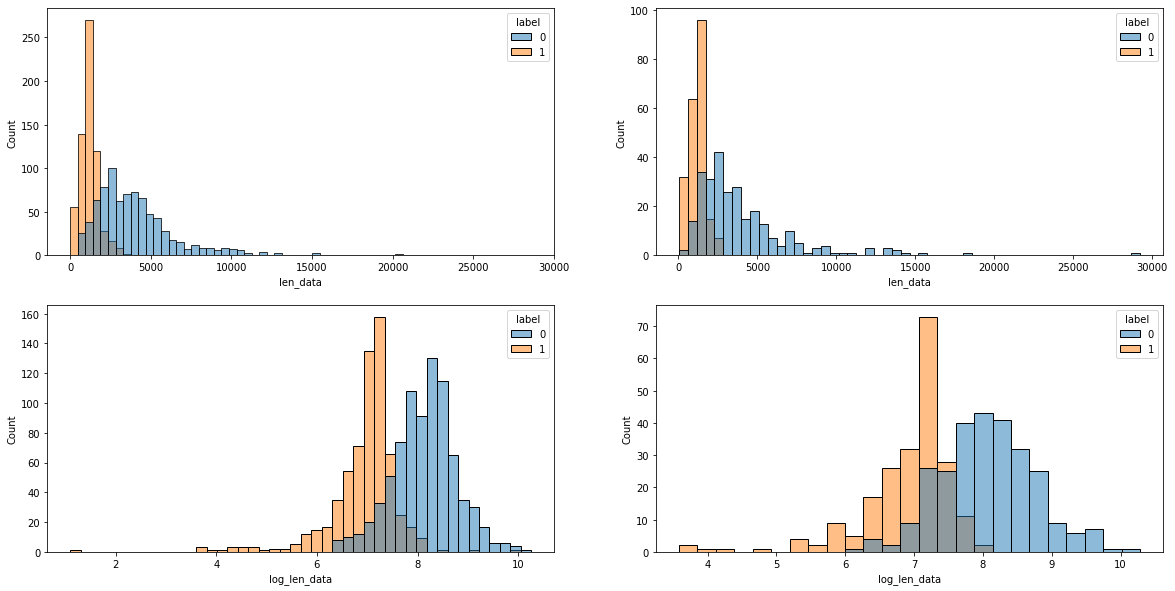

In [77]:
fig,(ax1,ax2)=plt.subplots(2,2,figsize=(20,10))
sns.histplot(data = df_train, x = 'len_data', hue = 'label', ax=ax1[0])
sns.histplot(data = df_test, x = 'len_data', hue = 'label', ax = ax1[1])

sns.histplot(data = df_train, x = 'log_len_data', hue = 'label', ax = ax2[0])
sns.histplot(data = df_test, x = 'log_len_data', hue = 'label', ax = ax2[1])


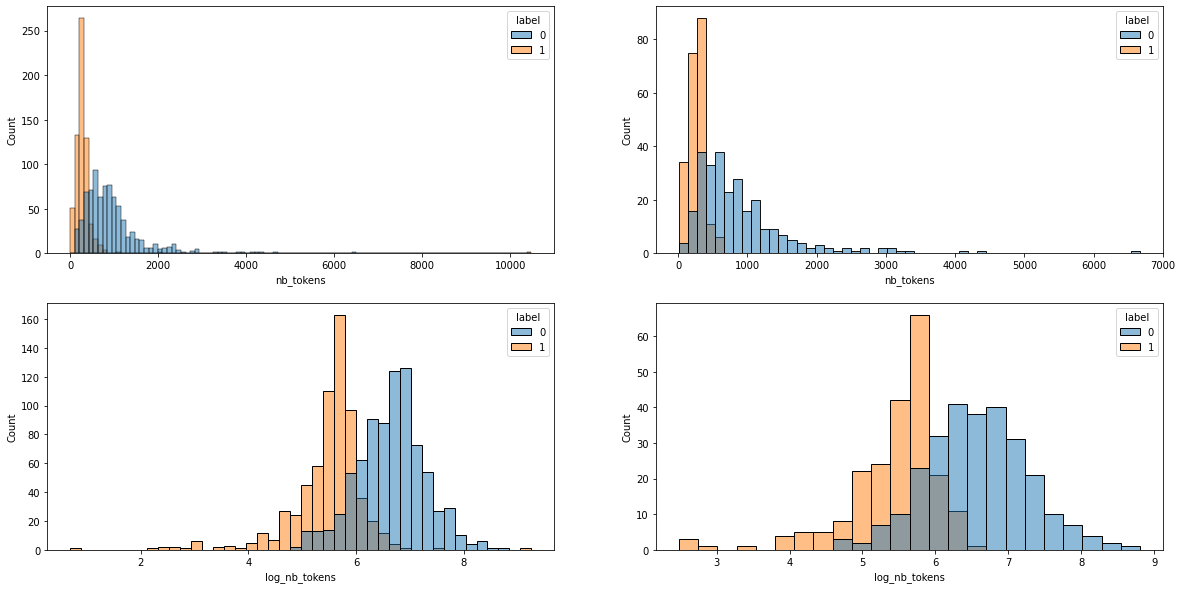

In [78]:
fig,(ax1,ax2)=plt.subplots(2,2,figsize=(20,10))
sns.histplot(data = df_train, x = 'nb_tokens', hue = 'label', ax = ax1[0])
sns.histplot(data = df_test, x = 'nb_tokens', hue = 'label', ax = ax1[1])

sns.histplot(data = df_train, x = 'log_nb_tokens', hue = 'label', ax = ax2[0])
sns.histplot(data = df_test, x = 'log_nb_tokens', hue = 'label', ax = ax2[1])

In [46]:
import spacy 
!python3 -m spacy download fr_core_news_md
from spacy.lang.fr.examples import sentences 

nlp = spacy.load("fr_core_news_md")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/explosion/spacy-models/releases/download/fr_core_news_md-3.4.0/fr_core_news_md-3.4.0-py3-none-any.whl (45.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.

Text(0.5, 0.98, 'Average word length in each tweet')

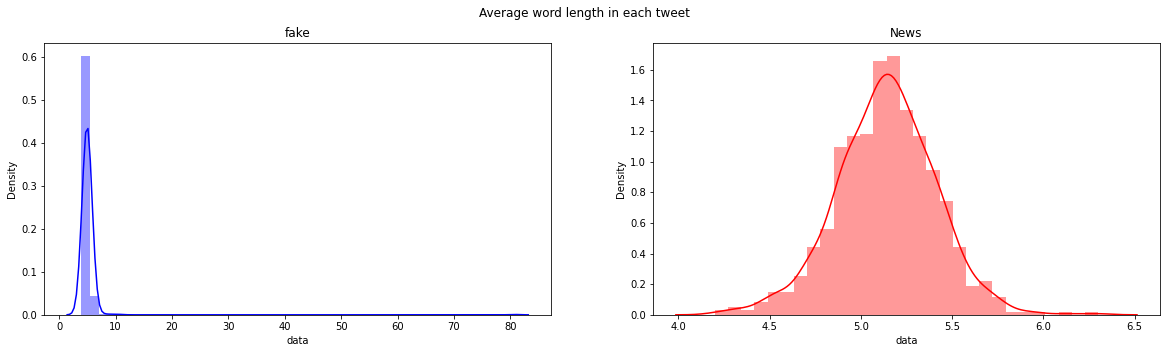

In [57]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,5))
word=df_train[df_train['label']==1]['data'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='blue')
ax1.set_title('fake')
word=df_train[df_train['label']==0]['data'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('News')
fig.suptitle('Average word length in each tweet')

In [79]:
def create_corpus(label):
    corpus=[]
    
    for x in df_train[df_train['label']==label]['data'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [80]:
np.array(stop)

array({'étés', 'seriez', 'étions', 'soyez', 'ou', 'serons', 'ayez', 'suis', 'eus', 'est', 'étants', 'aurais', 'ayants', 'eue', 'une', 'tu', 'sommes', 'soient', 'aient', 'il', 'même', 'vos', 'auriez', 'eussions', 'auraient', 'aurez', 'eux', 'seront', 'c', 'qui', 'moi', 'fussiez', 'des', 'eûtes', 'toi', 'eût', 'mes', 'étais', 'tes', 'eu', 'étante', 'été', 'qu', 'soyons', 'serai', 'auront', 'ces', 'ce', 'ayons', 'étée', 'êtes', 'étaient', 'eûmes', 'dans', 'me', 'aies', 'fûtes', 'la', 'eues', 'était', 'seraient', 'étantes', 'ai', 'ton', 'avons', 'aux', 'eut', 'notre', 'ont', 'sont', 'fût', 'j', 'votre', 'avez', 'y', 'étiez', 's', 'aurons', 'et', 'ta', 'es', 'on', 'pas', 'ayantes', 'aura', 'au', 'n', 'par', 'ma', 'avais', 'eussiez', 'aurai', 'aie', 'le', 'serait', 'seras', 'fussions', 'aurions', 'soit', 'fusse', 'avait', 'd', 'nous', 'un', 'que', 'à', 'serais', 'leur', 'auras', 'fusses', 'as', 'te', 'ayant', 'eurent', 'je', 'serez', 'les', 'aurait', 'se', 'ait', 'sois', 'l', 'mon', 'pour', 

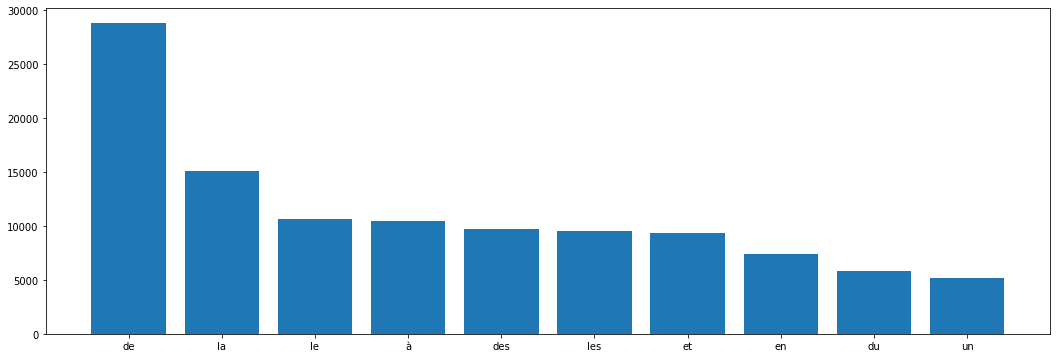

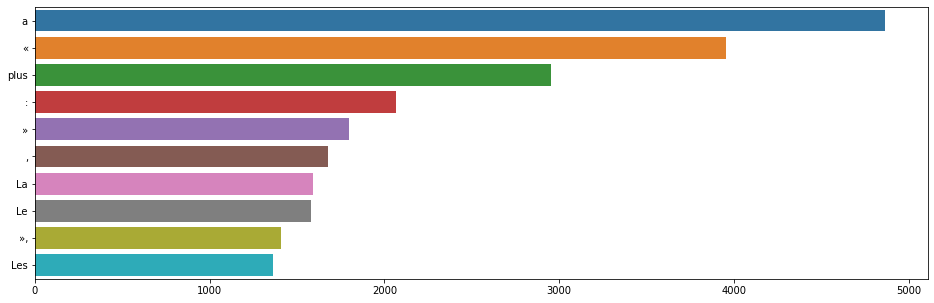

In [82]:
corpus=create_corpus(0)
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y)

plt.figure(figsize=(16,5))
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)


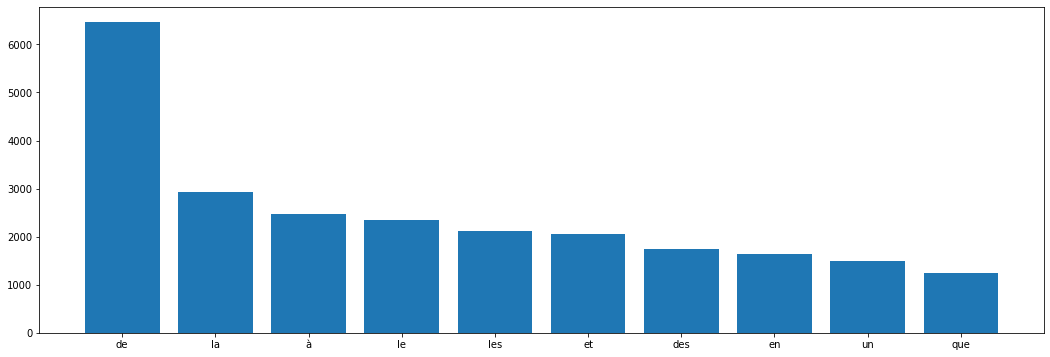

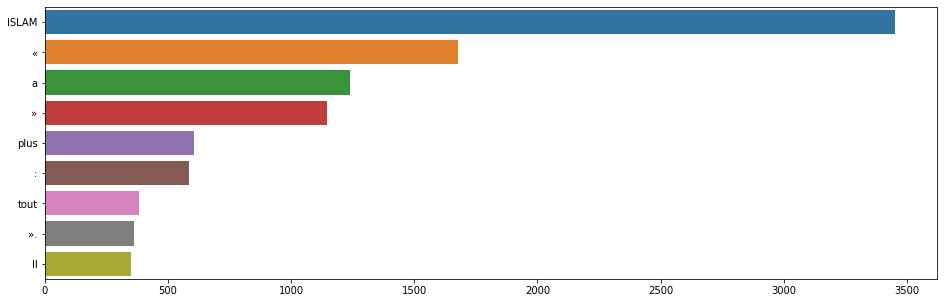

In [83]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    

plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y)

plt.figure(figsize=(16,5))
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)